<a href="https://colab.research.google.com/github/juliuserbach/Semantic-Features/blob/master/Kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate "https://onedrive.live.com/download?cid=EA356294C6263A37&resid=EA356294C6263A37%21100445&authkey=ABd__XT-VVc8aNs" -O nuscenes_mini.tgz

--2020-04-03 21:17:19--  https://onedrive.live.com/download?cid=EA356294C6263A37&resid=EA356294C6263A37%21100445&authkey=ABd__XT-VVc8aNs
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://k1pijq.am.files.1drv.com/y4mLUV0LAJ5h9RpkuwicXlGnORRLAy4b3L8AxwekMyaVc9UIoPOCdj7SzqgiZwQ5PTc0nXDkuRG-b3Up2VvHMVmhjzoibaJ0ZAUKBSllpyBMKCUQ-rJVElrAOXz3HFN98EcnI5iUDbjfMcnRKJOEuoGp53BY5LcWiQydihOEJqeWpUdYSjKAnrjKAPyUBOxGR6M50sv3DlVRwAwDZ4cGbMksA/v1.0-mini.tgz?download&psid=1 [following]
--2020-04-03 21:17:20--  https://k1pijq.am.files.1drv.com/y4mLUV0LAJ5h9RpkuwicXlGnORRLAy4b3L8AxwekMyaVc9UIoPOCdj7SzqgiZwQ5PTc0nXDkuRG-b3Up2VvHMVmhjzoibaJ0ZAUKBSllpyBMKCUQ-rJVElrAOXz3HFN98EcnI5iUDbjfMcnRKJOEuoGp53BY5LcWiQydihOEJqeWpUdYSjKAnrjKAPyUBOxGR6M50sv3DlVRwAwDZ4cGbMksA/v1.0-mini.tgz?download&psid=1
Resolving k1pijq.am.files.1drv.com (k1pijq.am.files.1drv

In [0]:
!mkdir data
!tar -xzf nuscenes_mini.tgz -C data

In [3]:
!pip install nuscenes-devkit

# Ignoriere einfach den Error den er hier schmeißt.

     |████████████████████████████████| 215kB 3.4MB/s 
     |████████████████████████████████| 143kB 11.4MB/s 
     |████████████████████████████████| 2.1MB 10.0MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 1.1MB 28.7MB/s 
  Created wheel for fire: filename=fire-0.3.0-py2.py3-none-any.whl size=111108 sha256=db4c8436eb211f364efa7be12a71f8d2da9d8c5302e235b2a3c34b077b6e9148
  Stored in directory: /root/.cache/pip/wheels/92/62/79/6a40acd827ec9d78d610be311820ecf8e41db024d8b1d12ace
Successfully built fire
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Found existing installation: pyzmq 17.0.0
    Uninstalling pyzmq-17.0.0:
      Successfully uninstalled pyzmq-17.0.0


In [7]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='data/', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.0 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [0]:
def pcl_to_image(pointcloud, intrinsic_matrix, img_shape):
  """ Projects a pointcloud to camera image.

  Returns:
      depth_image (numpy array of shape (image_height, image_width),
          dtype=np.float32): Depth image (Z), with depth in m.
  """
  image_width = img_shape[1]
  image_height = img_shape[0]

  depth_image = np.zeros((image_height, image_width), dtype=np.float32)

  pcl_inside_view = pointcloud[pointcloud[:, 2] > 0, :]
  pcl_inside_view_xyz = np.hstack((pcl_inside_view[:, :3],
                                    np.ones((pcl_inside_view.shape[0], 1))))

  pcl_projected = np.array(intrinsic_matrix).dot(pcl_inside_view_xyz.T)
  pixel = np.rint(pcl_projected / pcl_projected[2, :]).astype(int)[:2, :]

  index_bool = np.logical_and(
      np.logical_and(0 <= pixel[0], pixel[0] < image_width),
      np.logical_and(0 <= pixel[1], pixel[1] < image_height))
  pixel = pixel[:, index_bool]

  pcl_inside_view = pcl_inside_view[index_bool, :]

  # Considering occlusion, we need to be careful with the order of assignment
  # descending order according to the z coordinate.
  index_sort = pcl_inside_view[:, 2].argsort()[::-1]
  pixel = pixel[:, index_sort]
  pcl_inside_view = pcl_inside_view[index_sort, :]

  depth_image[pixel[1], pixel[0]] = pcl_inside_view[:, 2]

  return depth_image

In [41]:
boston_scene = nusc.field2token('scene', 'name', 'scene-0757')[0]
nusc.scene[0]
cam = nusc.sensor[0]['token']
print(nusc.calibrated_sensor[0])
print(nusc.sample_data[10])
lidar = nusc.sensor[6]

{'token': 'f4d2a6c281f34a7eb8bb033d82321f79', 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a', 'translation': [3.412, 0.0, 0.5], 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088], 'camera_intrinsic': []}
{'token': '2ecfec536d984fb491098c9db1404117', 'sample_token': '356d81f38dd9473ba590f39e266f54e5', 'ego_pose_token': '2ecfec536d984fb491098c9db1404117', 'calibrated_sensor_token': 'f4d2a6c281f34a7eb8bb033d82321f79', 'timestamp': 1532402928269133, 'fileformat': 'pcd', 'is_key_frame': False, 'height': 0, 'width': 0, 'filename': 'sweeps/RADAR_FRONT/n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402928269133.pcd', 'prev': 'b933bbcb4ee84a7eae16e567301e1df2', 'next': '79ef24d1eba84f5abaeaf76655ef1036', 'sensor_modality': 'radar', 'channel': 'RADAR_FRONT'}


(3, 4)
(4, 4)
(370, 1226, 3)
(370, 1226)

Sequence: 04

Frame range: None

RGB stereo pair baseline [m]: 0.5379044891402804

First timestamp: 0:00:00

Second ground truth pose:
[[  1.      -0.0042   0.0035  -0.0966]
 [  0.0042   1.      -0.0042  -5.9078]
 [ -0.0035   0.0042   1.     313.0445]
 [  0.       0.       0.       1.    ]]


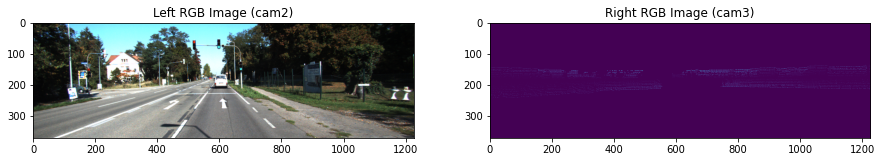

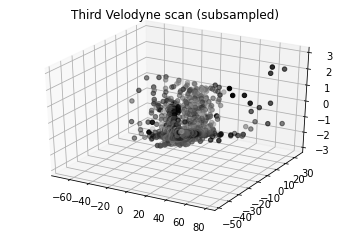

In [0]:
import numpy as np



# This is the main loop!


rgb_img = np.asarray(first_cam2)
print(rgb_img.shape)
depth_img = pcl_to_image(third_velo[:, :3] * 1000, P_cam2.dot(T_cam2_velo), rgb_img.shape)

print(depth_img.shape)
cv2.imwrite('depth.png', depth_img * 1000)

# Display some of the data
np.set_printoptions(precision=4, suppress=True)
print('\nSequence: ' + str(dataset.sequence))
print('\nFrame range: ' + str(dataset.frames))

print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

print('\nFirst timestamp: ' + str(dataset.timestamps[0]))
print('\nSecond ground truth pose:\n' + str(second_pose))

f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(first_cam2)
ax[0].set_title('Left RGB Image (cam2)')

ax[1].imshow(depth_img * 1000)
ax[1].set_title('Right RGB Image (cam3)')

f2 = plt.figure()
ax2 = f2.add_subplot(111, projection='3d')
# Plot every 100th point so things don't get too bogged down
velo_range = range(0, third_velo.shape[0], 100)
ax2.scatter(third_velo[velo_range, 0],
            third_velo[velo_range, 1],
            third_velo[velo_range, 2],
            c=third_velo[velo_range, 3],
            cmap='gray')
ax2.set_title('Third Velodyne scan (subsampled)')

plt.show()